In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
face_cascade = cv2.CascadeClassifier('./Source Code/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./Source Code/haarcascades/haarcascade_eye.xml')

def cropped_images(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

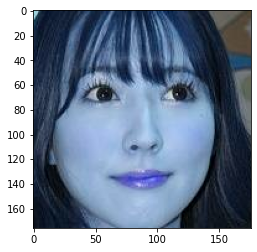

In [3]:
original_image = cropped_images('./testing/yua.jpg')
plt.imshow(original_image)

In [4]:
path_to_data = "./dataset"
path_to_data_crop = "./dataset/crop/"

In [5]:
#create path to data
import os
img_dir = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dir.append(entry.path)

In [6]:
img_dir

['./dataset\\Aika_Yumeno',
 './dataset\\Aimi_Yoshikawa',
 './dataset\\Ai_Uehara',
 './dataset\\yua_mikami']

In [7]:
#if folder crop exist => remove
import shutil
if os.path.exists(path_to_data_crop):
    shutil.rmtree(path_to_data_crop)
os.mkdir(path_to_data_crop)

In [8]:
crop_img_dir = []
pornstar_dict = {}
for img_dr in img_dir:
    count = 1
    pornstar_name = img_dr.split('\\')[-1]
    
    pornstar_dict[pornstar_name] = []
    
    for entry in os.scandir(img_dr):
        roi_color = cropped_images(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_data_crop + pornstar_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                crop_img_dir.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = pornstar_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            pornstar_dict[pornstar_name].append(cropped_file_path)
            count += 1    

Generating cropped images in folder:  ./dataset/crop/Aika_Yumeno
Generating cropped images in folder:  ./dataset/crop/Aimi_Yoshikawa
Generating cropped images in folder:  ./dataset/crop/Ai_Uehara
Generating cropped images in folder:  ./dataset/crop/yua_mikami


In [9]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

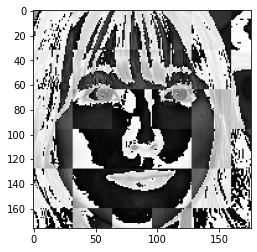

In [10]:
im_har = w2d(original_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [11]:
porn_dict = {}
count = 0
for pornstar_name in pornstar_dict.keys():
    porn_dict[pornstar_name] = count
    count+=1
porn_dict

{'Aika_Yumeno': 0, 'Aimi_Yoshikawa': 1, 'Ai_Uehara': 2, 'yua_mikami': 3}

In [12]:
x = []
y = []
for pornstar_name, training_data in pornstar_dict.items():
    for training_image in training_data:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_img = cv2.resize(img, (32,32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har , (32,32))
        combine_img = np.vstack((scaled_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        x.append(combine_img)
        y.append(porn_dict[pornstar_name])

In [13]:
x

[array([[ 37],
        [ 39],
        [ 50],
        ...,
        [  3],
        [ 33],
        [244]], dtype=uint8),
 array([[175],
        [159],
        [223],
        ...,
        [ 11],
        [190],
        [251]], dtype=uint8),
 array([[200],
        [205],
        [223],
        ...,
        [ 37],
        [245],
        [196]], dtype=uint8),
 array([[ 57],
        [ 74],
        [ 93],
        ...,
        [168],
        [247],
        [ 17]], dtype=uint8),
 array([[ 70],
        [114],
        [156],
        ...,
        [144],
        [236],
        [ 16]], dtype=uint8),
 array([[21],
        [24],
        [33],
        ...,
        [18],
        [37],
        [39]], dtype=uint8),
 array([[ 20],
        [ 21],
        [ 31],
        ...,
        [238],
        [228],
        [221]], dtype=uint8),
 array([[ 39],
        [ 43],
        [ 53],
        ...,
        [237],
        [234],
        [198]], dtype=uint8),
 array([[ 21],
        [ 20],
        [ 29],
        ...,
    

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [15]:
x = np.array(x).reshape(len(x), 4096).astype(float)
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state = 0)
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipeline.fit(x_train, y_train)
pipeline.score(x_test, y_test)

0.782608695652174

In [16]:
print(classification_report(y_test, pipeline.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.91      1.00      0.95        10
           2       0.56      1.00      0.71         5
           3       1.00      0.33      0.50         3

    accuracy                           0.78        23
   macro avg       0.87      0.68      0.68        23
weighted avg       0.86      0.78      0.76        23



In [17]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [18]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [19]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.678022,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.573626,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.662637,{'logisticregression__C': 1}


In [20]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [21]:
best_estimators['svm'].score(x_test,y_test)

0.8695652173913043

In [22]:
best_estimators['random_forest'].score(x_test,y_test)

0.6521739130434783

In [23]:
best_estimators['logistic_regression'].score(x_test,y_test)

0.9130434782608695

In [24]:
best_clf = best_estimators['svm']

Text(69.0, 0.5, 'real')

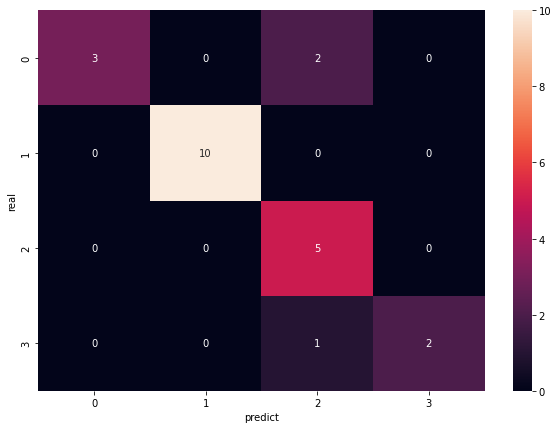

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(x_test))
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot = True)
plt.xlabel('predict')
plt.ylabel('real')

In [26]:
import joblib
import json
#save the model pkl
joblib.dump(best_clf, 'model.pkl')
with open('dictionary.json','w') as f:
    f.write(json.dumps(porn_dict))